In [1]:
from typing import List, Dict, Any, Optional, Union
import pandas as pd
import networkx as nx

from tqdm import tqdm
from rdflib import Graph, URIRef, Literal, Namespace
from pathlib import Path
from operator import itemgetter
from matplotlib import pyplot as plt
from rdflib.namespace import XSD, RDF, RDFS, SKOS

from rdflib.extras.external_graph_libs import *

Visualizing the graph may improve our understanding of the data in the graph. The IReC GitHub repository contains some instructions for visualizing the graph with GraphDB. The `unfeatured_graph.ttl` file probably contains the most appropriate level of information for visualizing our graph. 

In this notebook, we would like to analyse the graph to identify potential concepts. The idea being that they could be added to a manually curated AEC conceptualization. For analysis, we'll use the `featured_graph.ttl` file.

We'll look at some basic graph analysis approaches:
* **Paths** we could be interested in, e.g.;
  * X constitutes Y constitutes Z etc
  
* Finding **central nodes** based, e.g.;
  * which nodes are likely common high-level classes, e.g., materials, systems, etc. (would we want to reweigh phrasese that contain such words?)
  * features that we could consider include the degree (number of edges for a node), betweennes (number of shortest paths that pass through the node), and 'page rank' (importance of node based on importance of related nodes)
      * concept-concept shortest paths may identify related terms, e.g., determine spans that connect the concepts `fire doorset` and `protected corridor`
      * betweennes centrality may suggest high level concepts, e.g., `materials`, `systems` and so on
      * page rank; which spans are connected to the most influential spans (ones with high betweennes or connected direclty to concepts)
* **Community detection**; find groups of closely connected nodes, e.g., we'd like to find all nodes that are directly related to spans revolving around materials. Approaches to use include Label propagation and Unfolding (Louvain) to compute a bottom-up grouping of connected nodes.

To do:
* continue exploring SPARQL + networkX combinations
  * weighted graph?
* wikiClassLabel; turn into an edge with a span as its representation 
check out how to create useful aggregate queries in SPARQL
* For now, we'll avoid looking at pattern matching through worst case optimal join (WCOJ) algorithms.

Add to requirements.txt:
* scipy==1.8
* networkx==3.0

In [2]:
graph_output_fp = Path.cwd().joinpath("data", "graph_output")

In [3]:
IREC_spans_URL = "https://spans.irec.org/"
IREC_concepts_URL = "https://concepts.irec.org/"

### Load Graph

In [4]:
irec_graph = Graph()
graph_data_fp = Path.cwd().joinpath("data", "graph_data")
irec_graph.parse(graph_data_fp.joinpath("IREC.rdf"))

<Graph identifier=Na1199401c1cd447a83f4b76baf0bbdd9 (<class 'rdflib.graph.Graph'>)>

In [5]:
irec_graph.parse(graph_output_fp.joinpath("unfeatured_graph.ttl"))
UG = rdflib_to_networkx_graph(irec_graph)

In [6]:
# convert to NetworkX graph
irec_graph.parse(graph_output_fp.joinpath("featured_graph.ttl"))
FG = rdflib_to_networkx_graph(irec_graph)
# G = rdflib_to_networkx_digraph(irec_graph)

## Combine SPARQL and graph computations (work in progress from here on)

### Multiple paths; weighted graph
* We could store the subject node UID and object node UID separately. This may be useful when working with concepts in more detail. We don't really need this now, because for spans the UID is simply a coversion: `urllib.parse.quote('span')`

In [7]:
def get_single_type_edges(graph: Graph, edge_type: str = "irec:constitutes"):
    """
        We'll treate every edge as a bidirectional relation for now
    """
    test_query = """
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    prefix irec: <https://schema.irec.org/#>
    prefix skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?subject ?object
    WHERE {
        ?subject_node PREDICATE|^PREDICATE ?object_node .
        ?subject_node rdfs:label ?subject .
        ?object_node rdfs:label|skos:prefLabel ?object . 
    }
    LIMIT 25000
    """.replace("PREDICATE", edge_type)
    return irec_graph.query(test_query)

In [8]:
edge_types = [
    "irec:constitutes",                    # exact word overlap
    "irec:isMorphologicallySimilarTo",     # similar words
    "irec:isSemanticallySimilarTo",        # similar contexts
    "irec:related",                        # manually grabbed from Approved documents indices
    "irec:hasAcronym",                     # acronyms are naive or index based, not very important 
    "skos:related",                        # manually grabbed from Approved documents indices
    "skos:exactMatch"                      # the span has a concept with equivalent label
] 

In [9]:
edge_weights = [
    2,                    # exact word overlap
    1,                    # similar words
    1,                    # similar contexts
    10,                   # manually grabbed from Approved documents indices
    1,                    # acronyms are naive or index based, not very important 
    5,                    # manually grabbed from Approved documents indices
    10                    # the span has a concept with equivalent label
] 
maximum_distance = sum(edge_weights)

In [10]:
# REMOVE LIMIT FROM get_single_type_edges query; need to consider parallel execution here
distance_dict = {}
for edge_type, edge_weight in tqdm(zip(edge_types, edge_weights)):
    sparql_result = get_single_type_edges(irec_graph, edge_type)
    for r in sparql_result:
        if r.subject != r.object:
            subj = str(r.subject)
            obj = str(r.object)
            # figure out weights (will be distances in the graph actually, so high value is less related)
            if subj not in distance_dict:
                distance_dict[subj] = {obj : maximum_distance - edge_weight}
            else:
                if obj not in distance_dict[subj]:
                    distance_dict[subj][obj] = maximum_distance - edge_weight
                else:
                    distance_dict[subj][obj] -= edge_weight

7it [04:36, 39.46s/it] 


In [11]:
network = nx.Graph()
network.add_weighted_edges_from([(s, o, w) for s, r in distance_dict.items() for o, w in r.items()])

In [12]:
# mst = nx.minimum_spanning_tree(network)

In [13]:
# plt.figure(figsize=(10, 10))
# nx.draw_networkx(mst, with_labels=True, node_size = 20)
# plt.show()

In [14]:
def show_community(idx: Union[str, int], community: set, network: nx.Graph = network):
    print(f"Community [{idx}] of size {len(community)}, top 10 spans by degree:")
    span_degree_dict = dict(network.degree(g for g in community))
    spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
    for idx, span_nedges in enumerate(spans_sorted_by_num_edges[:10]):
        span_node, num_edges = span_nedges
        [print(f"{idx}: {s_triple[2]} [{num_edges}]") for s_triple in irec_graph.triples((None, RDFS.label, Literal(span_node, lang='en')))]

    mst = nx.minimum_spanning_tree(network.subgraph(community))
    plt.figure(figsize=(10, 10))
    nx.draw_networkx(mst, with_labels=True, node_size = 20)
    plt.show()

In [50]:
def divide_into_communities(network: nx.Graph, existing_community: set = None, existing_community_idx: str = None):
    # divide the network into communities
    louvain = nx.algorithms.community.louvain.louvain_communities(network)
       
    for idx, community in enumerate(louvain):
            
#         if not "party wall" in community:
#             continue
        
        new_idx = f"{existing_community_idx}.{idx}" if existing_community_idx else str(idx)
            
        if len(community) > 50: # max size of community
#             print(f"Community [{new_idx}] of size {len(community)} will be split further")
            divide_into_communities(network.subgraph(community), 
                                    existing_community=community, 
                                    existing_community_idx=new_idx)
        else:
            show_community(idx, community)
    
    

Community [0] of size 22, top 10 spans by degree:
0: wall [213]
1: wall floor [18]
2: framed wall [13]
3: party wall [11]
4: wall First floor 1 [7]
5: separating wall [6]
6: separating wall  [5]
7: a separating floor separating wall [4]
8: regulation B3 ( 2 ) [4]
9: internal wall [3]


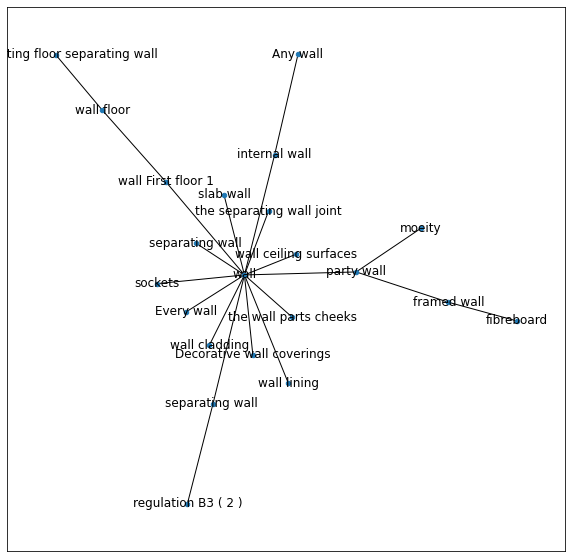

In [16]:
divide_into_communities(network)

Community [3] of size 23, top 10 spans by degree:
0: wall [213]
1: partition [18]
2: party wall [11]
3: separating wall [6]
4: a stud wall partition [6]
5: separating wall  [5]
6: a separating floor separating wall [4]
7: wall partition [4]
8: regulation B3 ( 2 ) [4]
9: internal wall [3]


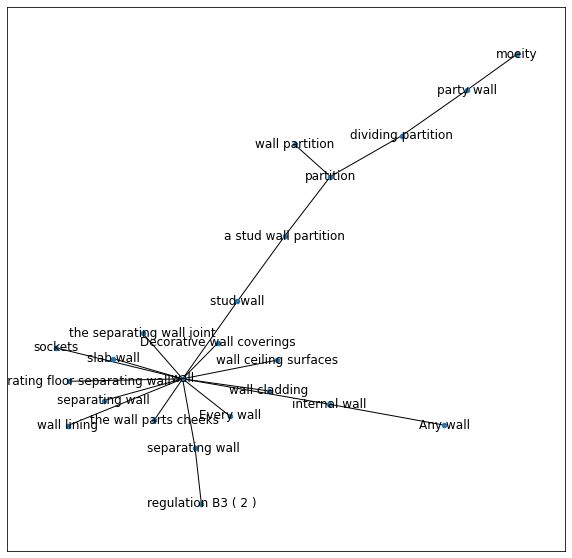

In [25]:
### TODO; pick a node in the graph and all of the nodes at distance X, then compute the communities

divide_into_communities(nx.ego_graph(network, "separating wall", radius=50))

Community [3] of size 26, top 10 spans by degree:
0: wall [213]
1: an layer [20]
2: framed wall [13]
3: party wall [11]
4: separating wall [6]
5: separating wall  [5]
6: an angle [5]
7: a separating floor separating wall [4]
8: regulation B3 ( 2 ) [4]
9: an wall [4]


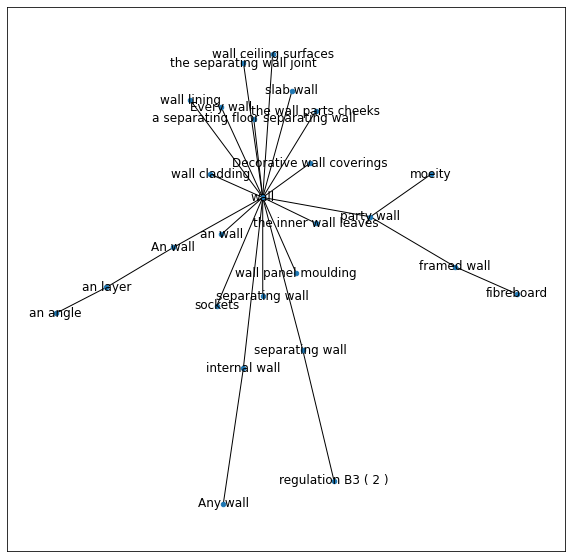

In [46]:
### AIM; pick a node in the graph and all of the nodes at path_length X, then compute the communities
# I think Louvain results in something else each time
max_path_steps = 3
nodes = set(nx.single_source_shortest_path_length(network, "party wall", cutoff=max_path_steps).keys())
subgraph = network.subgraph(nodes)
divide_into_communities(subgraph)

Community [0] of size 8, top 10 spans by degree:
0: a material alteration [21]
1: material alteration [16]
2: the material alteration [14]
3: the material change [13]
4: material change of [11]
5: a material change [10]
6: material change [5]
7: a material change of [3]


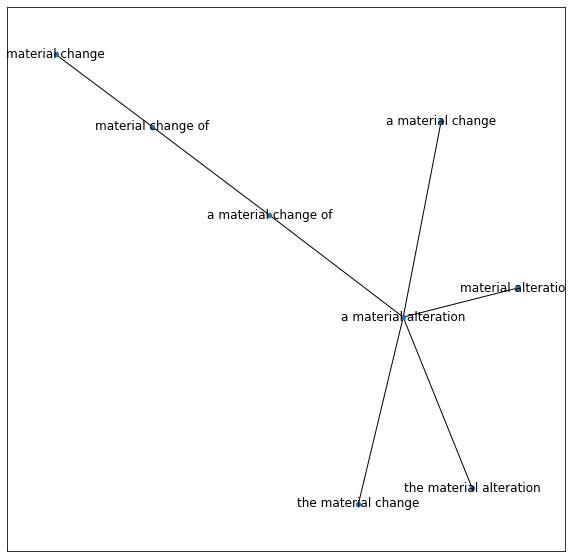

Community [1] of size 41, top 10 spans by degree:
0: material [80]
1: accordance [49]
2: plastic [49]
3: layer [36]
4: objects [31]
5: unprotected area  [25]
6: equipment [22]
7: lining [21]
8: stone [20]
9: thermoplastic material [18]


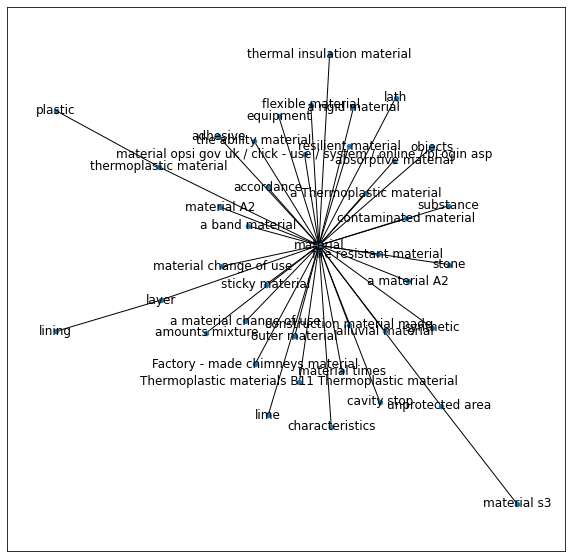

Community [2] of size 6, top 10 spans by degree:
0: insulating material [17]
1: the absorbent material [16]
2: the material [16]
3: absorbent material [7]
4: combustible material [7]
5: with absorbent material [6]


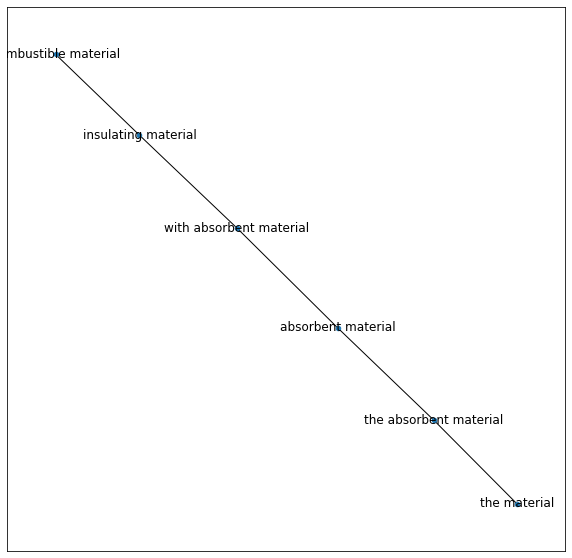

Community [3] of size 11, top 10 spans by degree:
0: a granular material [22]
1: a material [22]
2: a porous material [21]
3: Fiber - reinforced composite material [11]
4: mesh [11]
5: a ceramic material [11]
6: fibrous material [8]
7: any laminated material [6]
8: granular material [6]
9: composite construction material [4]


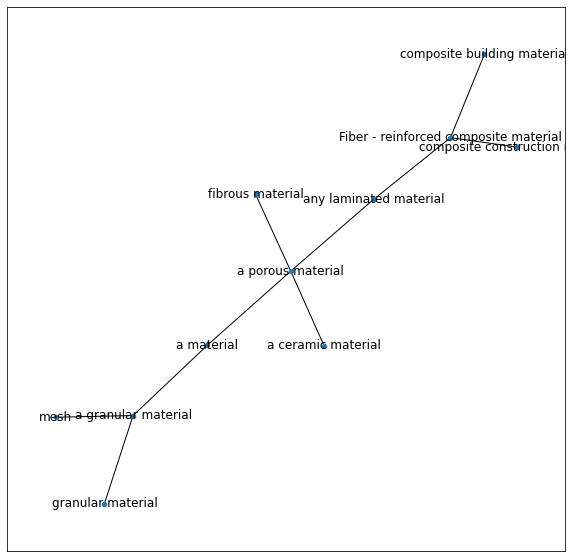

Community [4] of size 3, top 10 spans by degree:
0: mortar material [23]
1: solid material [18]
2: filler material [6]


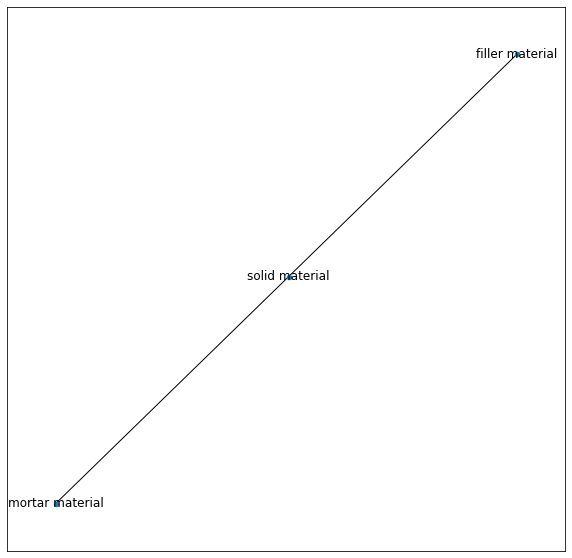

Community [5] of size 12, top 10 spans by degree:
0: substrate [24]
1: textile material [21]
2: stone material [20]
3: black material [16]
4: processed material [15]
5: the base material [13]
6: magnetic material [8]
7: base material [7]
8: biological material [7]
9: rock material [6]


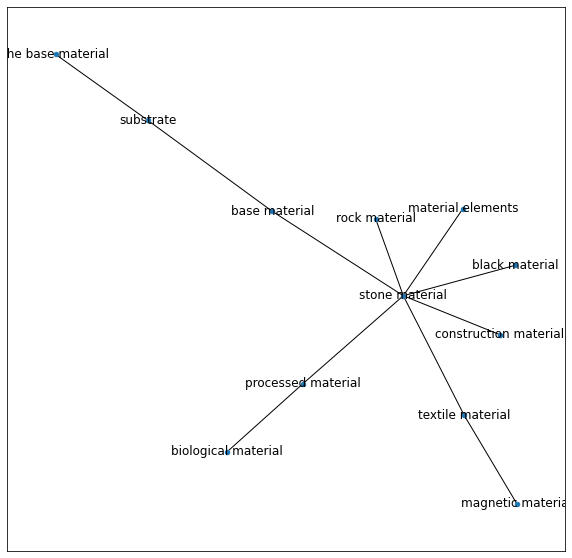

In [52]:
### AIM; pick a node in the graph and all of the nodes at path_length X, then compute the communities
# different result each time
max_path_weight = 1 * maximum_distance
nodes = set(nx.single_source_dijkstra_path(network, "material", cutoff=max_path_weight).keys())
subgraph = network.subgraph(nodes)
divide_into_communities(subgraph)


In [ ]:
# L = nx.laplacian_matrix(G)

### Single term (old code for testing)

In [24]:
# Single term query
user_query = 'wall'
test_query = """
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix irec: <https://schema.irec.org/#>

SELECT ?other_label
WHERE {
    ?a irec:related|^irec:related ?b . 
    ?b rdfs:label ?other_label .
    ?a rdfs:label ?value .
    FILTER (CONTAINS(LCASE(str(?value)), "QUERY"))
}
""".replace('QUERY', user_query)

In [26]:
res = irec_graph.query(test_query)    

In [58]:
from time import time

In [64]:
len([(Literal(user_query, lang='en'), r.other_label) for r in res if r.other_label != Literal(user_query)])

193

In [71]:
# trying to direclty create the graph from the sparql result
start = time()
impact_graph = nx.Graph()
impact_graph.add_weighted_edges_from([(Literal(user_query, lang='en'), r.other_label, {'weight': 1}) for r in res if r.other_label != Literal(user_query)])
print(f"took {time()-start} seconds")

took 0.0056149959564208984 seconds


In [72]:
# For now we'll separate the creation of the edgelist, rather than creating the graph directly
start = time()
edge_list = []
weight_list = []
for row in res:
    if Literal(user_query) != row.other_label:
        edge_list.append((Literal(user_query), row.other_label, {"weight": 1}))
impact_graph = nx.Graph()
impact_graph.add_weighted_edges_from(edge_list)
print(f"took {time()-start} seconds")

took 0.00557708740234375 seconds


In [51]:
print(f"Number of edges related to `{user_query}`: {len(edge_list)}")

Number of edges related to `wall`: 193


In [53]:
span_degree_dict = dict(UG.degree((g for g in impact_graph.nodes())))
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]

Top 20 spans by degree:


In [54]:
mst = nx.minimum_spanning_tree(impact_graph)

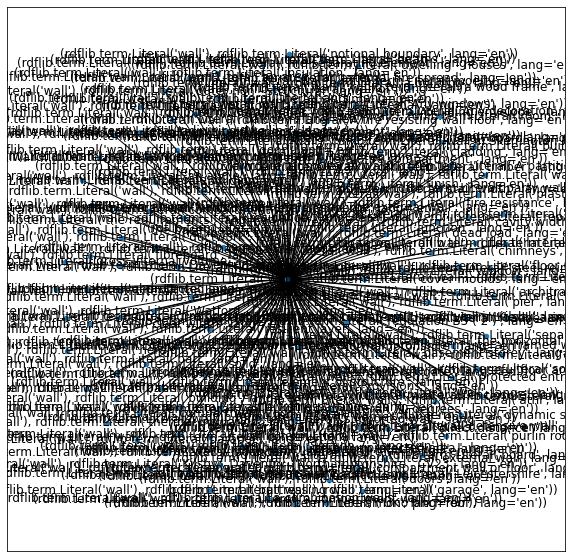

In [55]:

plt.figure(figsize=(10, 10))
nx.draw_networkx(mst, with_labels=True, node_size = 20)
plt.show()

### All relations of a type

In [16]:
# All constitutes relations
test_query = """
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix irec: <https://schema.irec.org/#>
prefix skos: <http://www.w3.org/2004/02/skos/core#>

SELECT DISTINCT ?aname ?bname
WHERE {
    ?a skos:exactMatch|skos:exactMatch ?b .
    ?a rdfs:label ?aname .
    ?b skos:prefLabel ?bname . 
}
"""
res = irec_graph.query(test_query)

In [17]:
for row in res:
    print(row)

(rdflib.term.Literal('absorption coefficient', lang='en'), rdflib.term.Literal('absorption coefficient', lang='en'))
(rdflib.term.Literal('electrical installation', lang='en'), rdflib.term.Literal('electrical installation', lang='en'))
(rdflib.term.Literal('flat', lang='en'), rdflib.term.Literal('flat', lang='en'))
(rdflib.term.Literal('flight', lang='en'), rdflib.term.Literal('flight', lang='en'))
(rdflib.term.Literal('floating floor', lang='en'), rdflib.term.Literal('floating floor', lang='en'))
(rdflib.term.Literal('frequency', lang='en'), rdflib.term.Literal('frequency', lang='en'))
(rdflib.term.Literal('frequency band', lang='en'), rdflib.term.Literal('frequency band', lang='en'))
(rdflib.term.Literal('gallery', lang='en'), rdflib.term.Literal('gallery', lang='en'))
(rdflib.term.Literal('greywater', lang='en'), rdflib.term.Literal('greywater', lang='en'))
(rdflib.term.Literal('handrail', lang='en'), rdflib.term.Literal('handrail', lang='en'))
(rdflib.term.Literal('infiltration', l

(rdflib.term.Literal('Explosives', lang='en'), rdflib.term.Literal('Explosives', lang='en'))
(rdflib.term.Literal('External lighting systems', lang='en'), rdflib.term.Literal('External lighting systems', lang='en'))
(rdflib.term.Literal('External ramps', lang='en'), rdflib.term.Literal('External ramps', lang='en'))
(rdflib.term.Literal('Fans', lang='en'), rdflib.term.Literal('Fans', lang='en'))
(rdflib.term.Literal('Fire alarm sounders', lang='en'), rdflib.term.Literal('Fire alarm sounders', lang='en'))
(rdflib.term.Literal('Fire compartments', lang='en'), rdflib.term.Literal('Fire compartments', lang='en'))
(rdflib.term.Literal('Fire doorsets', lang='en'), rdflib.term.Literal('Fire doorsets', lang='en'))
(rdflib.term.Literal('Fire engineer', lang='en'), rdflib.term.Literal('Fire engineer', lang='en'))
(rdflib.term.Literal('Fire safety strategy', lang='en'), rdflib.term.Literal('Fire safety strategy', lang='en'))
(rdflib.term.Literal('Fireplace surrounds', lang='en'), rdflib.term.Liter

(rdflib.term.Literal('Reception desks', lang='en'), rdflib.term.Literal('Reception desks', lang='en'))
(rdflib.term.Literal('Reference', lang='en'), rdflib.term.Literal('Reference', lang='en'))
(rdflib.term.Literal('Refrigeration', lang='en'), rdflib.term.Literal('Refrigeration', lang='en'))
(rdflib.term.Literal('Reinforcement', lang='en'), rdflib.term.Literal('Reinforcement', lang='en'))
(rdflib.term.Literal('Repair', lang='en'), rdflib.term.Literal('Repair', lang='en'))
(rdflib.term.Literal('Reservoirs', lang='en'), rdflib.term.Literal('Reservoirs', lang='en'))
(rdflib.term.Literal('Resilient bars', lang='en'), rdflib.term.Literal('Resilient bars', lang='en'))
(rdflib.term.Literal('Resilient layer insulation', lang='en'), rdflib.term.Literal('Resilient layer insulation', lang='en'))
(rdflib.term.Literal('Retail parks', lang='en'), rdflib.term.Literal('Retail parks', lang='en'))
(rdflib.term.Literal('Revisions', lang='en'), rdflib.term.Literal('Revisions', lang='en'))
(rdflib.term.Lit

(rdflib.term.Literal('assembly', lang='en'), rdflib.term.Literal('assembly', lang='en'))
(rdflib.term.Literal('assembly hall', lang='en'), rdflib.term.Literal('assembly hall', lang='en'))
(rdflib.term.Literal('audience', lang='en'), rdflib.term.Literal('audience', lang='en'))
(rdflib.term.Literal('audio', lang='en'), rdflib.term.Literal('audio', lang='en'))
(rdflib.term.Literal('automatic door', lang='en'), rdflib.term.Literal('automatic door', lang='en'))
(rdflib.term.Literal('baths', lang='en'), rdflib.term.Literal('Baths', lang='en'))
(rdflib.term.Literal('battery room', lang='en'), rdflib.term.Literal('battery room', lang='en'))
(rdflib.term.Literal('biomass', lang='en'), rdflib.term.Literal('biomass', lang='en'))
(rdflib.term.Literal('boarding house', lang='en'), rdflib.term.Literal('boarding house', lang='en'))
(rdflib.term.Literal('boiler rooms', lang='en'), rdflib.term.Literal('Boiler rooms', lang='en'))
(rdflib.term.Literal('boundaries', lang='en'), rdflib.term.Literal('Bounda

(rdflib.term.Literal('note', lang='en'), rdflib.term.Literal('note', lang='en'))
(rdflib.term.Literal('office', lang='en'), rdflib.term.Literal('office', lang='en'))
(rdflib.term.Literal('office building', lang='en'), rdflib.term.Literal('office building', lang='en'))
(rdflib.term.Literal('ozone', lang='en'), rdflib.term.Literal('ozone', lang='en'))
(rdflib.term.Literal('painting', lang='en'), rdflib.term.Literal('Painting', lang='en'))
(rdflib.term.Literal('painting', lang='en'), rdflib.term.Literal('painting', lang='en'))
(rdflib.term.Literal('panel', lang='en'), rdflib.term.Literal('panel', lang='en'))
(rdflib.term.Literal('parapet', lang='en'), rdflib.term.Literal('parapet', lang='en'))
(rdflib.term.Literal('parasite', lang='en'), rdflib.term.Literal('parasite', lang='en'))
(rdflib.term.Literal('permeability', lang='en'), rdflib.term.Literal('permeability', lang='en'))
(rdflib.term.Literal('photocopiers', lang='en'), rdflib.term.Literal('Photocopiers', lang='en'))
(rdflib.term.Lite

(rdflib.term.Literal('HEPA', lang='en'), rdflib.term.Literal('HEPA', lang='en'))
(rdflib.term.Literal('LPG', lang='en'), rdflib.term.Literal('LPG', lang='en'))
(rdflib.term.Literal('Notes', lang='en'), rdflib.term.Literal('Notes', lang='en'))
(rdflib.term.Literal('Reading', lang='en'), rdflib.term.Literal('Reading', lang='en'))
(rdflib.term.Literal('absorbent', lang='en'), rdflib.term.Literal('absorbent', lang='en'))
(rdflib.term.Literal('accreditation', lang='en'), rdflib.term.Literal('accreditation', lang='en'))
(rdflib.term.Literal('activities', lang='en'), rdflib.term.Literal('Activities', lang='en'))
(rdflib.term.Literal('adsorbent', lang='en'), rdflib.term.Literal('adsorbent', lang='en'))
(rdflib.term.Literal('aisle', lang='en'), rdflib.term.Literal('aisle', lang='en'))
(rdflib.term.Literal('alabaster', lang='en'), rdflib.term.Literal('alabaster', lang='en'))
(rdflib.term.Literal('alternating tread stairs', lang='en'), rdflib.term.Literal('alternating tread stairs', lang='en'))
(

(rdflib.term.Literal('gigawatt', lang='en'), rdflib.term.Literal('gigawatt', lang='en'))
(rdflib.term.Literal('glass wool', lang='en'), rdflib.term.Literal('glass wool', lang='en'))
(rdflib.term.Literal('glue', lang='en'), rdflib.term.Literal('glue', lang='en'))
(rdflib.term.Literal('gold', lang='en'), rdflib.term.Literal('gold', lang='en'))
(rdflib.term.Literal('gram', lang='en'), rdflib.term.Literal('gram', lang='en'))
(rdflib.term.Literal('granite', lang='en'), rdflib.term.Literal('granite', lang='en'))
(rdflib.term.Literal('green', lang='en'), rdflib.term.Literal('green', lang='en'))
(rdflib.term.Literal('green roof', lang='en'), rdflib.term.Literal('green roof', lang='en'))
(rdflib.term.Literal('greenhouse gas', lang='en'), rdflib.term.Literal('greenhouse gas', lang='en'))
(rdflib.term.Literal('gross', lang='en'), rdflib.term.Literal('gross', lang='en'))
(rdflib.term.Literal('handmade', lang='en'), rdflib.term.Literal('handmade', lang='en'))
(rdflib.term.Literal('harmonic', lang='

(rdflib.term.Literal('preventive maintenance', lang='en'), rdflib.term.Literal('preventive maintenance', lang='en'))
(rdflib.term.Literal('printing', lang='en'), rdflib.term.Literal('Printing', lang='en'))
(rdflib.term.Literal('privacy', lang='en'), rdflib.term.Literal('privacy', lang='en'))
(rdflib.term.Literal('protected area', lang='en'), rdflib.term.Literal('protected area', lang='en'))
(rdflib.term.Literal('quartzite', lang='en'), rdflib.term.Literal('quartzite', lang='en'))
(rdflib.term.Literal('realistic', lang='en'), rdflib.term.Literal('realistic', lang='en'))
(rdflib.term.Literal('recorded', lang='en'), rdflib.term.Literal('recorded', lang='en'))
(rdflib.term.Literal('redwood', lang='en'), rdflib.term.Literal('redwood', lang='en'))
(rdflib.term.Literal('residential buildings', lang='en'), rdflib.term.Literal('Residential buildings', lang='en'))
(rdflib.term.Literal('revolving door', lang='en'), rdflib.term.Literal('revolving door', lang='en'))
(rdflib.term.Literal('ridge', la

(rdflib.term.Literal('doorway', lang='en'), rdflib.term.Literal('doorway', lang='en'))
(rdflib.term.Literal('dry', lang='en'), rdflib.term.Literal('dry', lang='en'))
(rdflib.term.Literal('electric current', lang='en'), rdflib.term.Literal('electric current', lang='en'))
(rdflib.term.Literal('electric power', lang='en'), rdflib.term.Literal('electric power', lang='en'))
(rdflib.term.Literal('electrical wiring', lang='en'), rdflib.term.Literal('electrical wiring', lang='en'))
(rdflib.term.Literal('engineered bamboo', lang='en'), rdflib.term.Literal('engineered bamboo', lang='en'))
(rdflib.term.Literal('exit', lang='en'), rdflib.term.Literal('exit', lang='en'))
(rdflib.term.Literal('finish', lang='en'), rdflib.term.Literal('finish', lang='en'))
(rdflib.term.Literal('first', lang='en'), rdflib.term.Literal('first', lang='en'))
(rdflib.term.Literal('fitting', lang='en'), rdflib.term.Literal('fitting', lang='en'))
(rdflib.term.Literal('flue', lang='en'), rdflib.term.Literal('flue', lang='en'

(rdflib.term.Literal('fire door', lang='en'), rdflib.term.Literal('fire door', lang='en'))
(rdflib.term.Literal('fireplace', lang='en'), rdflib.term.Literal('fireplace', lang='en'))
(rdflib.term.Literal('gypsum', lang='en'), rdflib.term.Literal('Gypsum', lang='en'))
(rdflib.term.Literal('gypsum', lang='en'), rdflib.term.Literal('gypsum', lang='en'))
(rdflib.term.Literal('hardwood', lang='en'), rdflib.term.Literal('hardwood', lang='en'))
(rdflib.term.Literal('hazard', lang='en'), rdflib.term.Literal('hazard', lang='en'))
(rdflib.term.Literal('limestone', lang='en'), rdflib.term.Literal('limestone', lang='en'))
(rdflib.term.Literal('lobby', lang='en'), rdflib.term.Literal('lobby', lang='en'))
(rdflib.term.Literal('lost', lang='en'), rdflib.term.Literal('lost', lang='en'))
(rdflib.term.Literal('magnesium', lang='en'), rdflib.term.Literal('magnesium', lang='en'))
(rdflib.term.Literal('metamorphic rock', lang='en'), rdflib.term.Literal('metamorphic rock', lang='en'))
(rdflib.term.Literal('m

(rdflib.term.Literal('house', lang='en'), rdflib.term.Literal('house', lang='en'))
(rdflib.term.Literal('light', lang='en'), rdflib.term.Literal('Light', lang='en'))
(rdflib.term.Literal('light', lang='en'), rdflib.term.Literal('light', lang='en'))
(rdflib.term.Literal('measurement', lang='en'), rdflib.term.Literal('measurement', lang='en'))
(rdflib.term.Literal('shower', lang='en'), rdflib.term.Literal('shower', lang='en'))
(rdflib.term.Literal('structural element', lang='en'), rdflib.term.Literal('structural element', lang='en'))
(rdflib.term.Literal('width', lang='en'), rdflib.term.Literal('width', lang='en'))
(rdflib.term.Literal('concrete', lang='en'), rdflib.term.Literal('concrete', lang='en'))
(rdflib.term.Literal('damp', lang='en'), rdflib.term.Literal('damp', lang='en'))
(rdflib.term.Literal('equipment', lang='en'), rdflib.term.Literal('Equipment', lang='en'))
(rdflib.term.Literal('extension', lang='en'), rdflib.term.Literal('extension', lang='en'))
(rdflib.term.Literal('fire 

In [8]:
# For now we'll separate the creation of the edgelist, rather than creating the graph directly
edge_list = []
for row in res:
    if row.aname != row.bname:
        edge_list.append([row.aname, row.bname])

KeyboardInterrupt: 

In [ ]:
edge_list[:10]

In [ ]:
constitutes_graph = nx.Graph()
constitutes_graph.add_edges_from(edge_list)

In [ ]:
# We're grouping terms together that form a network of overlapping words, e.g., (thermal resistance, resistance, fire resistance, fire, etc...)
louvain = nx.algorithms.community.louvain.louvain_communities(constitutes_graph)

In [ ]:
# For each group we're going to determine a minimum spanning tree, to identify prominent nodes (rather than degree)
span_degree_dict = {}
mst_list_dict = {}
for idx, community in enumerate(louvain):
    span_degree_dict[idx] = dict(constitutes_graph.degree((g for g in community)))
#     spans_sorted_by_num_edges = sorted(span_degree_dict[idx].items(), key=itemgetter(1), reverse=True)
#     for idx, span_node in enumerate(spans_sorted_by_num_edges[:20]):
#         [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]
    temp_graph = nx.Graph()
    for edge_list in [list(constitutes_graph.edges(node)) for node in community]:
        temp_graph.add_edges_from(edge_list)
    mst = nx.minimum_spanning_tree(temp_graph)
    mst_list_dict[idx] = sorted(mst.edges(data=True))


In [ ]:
print([k for k in span_degree_dict.keys() if len(span_degree_dict[k]) > 100])

In [ ]:
mst_list_dict[6]

In [ ]:
span_degree_dict = dict(G.degree((g for g in constitutes_graph.nodes())))

In [ ]:
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]

### Identify Paths

### Connectedness

[{rdflib.term.Literal('Rainwater drainage systems', lang='en'),
  rdflib.term.Literal('metal', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#museum'),
  rdflib.term.URIRef('https://spans.irec.org/#the%20manufacturer'),
  rdflib.term.Literal('gradients', lang='en'),
  rdflib.term.Literal('a subject knowledge', lang='en'),
  rdflib.term.Literal('balcony', lang='en'),
  rdflib.term.Literal('tonal', lang='en'),
  rdflib.term.Literal('simplest organic molecule with one carbon atom and four hydrogen', lang='en'),
  rdflib.term.Literal('disadvantageous', lang='en'),
  rdflib.term.Literal('unable', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#an%20accessible%20bathroom'),
  rdflib.term.Literal('BS EN 1996 - 2', lang='en'),
  rdflib.term.Literal('hinge', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#Tanneries'),
  rdflib.term.URIRef('https://spans.irec.org/#unrestrained'),
  rdflib.term.Literal('resilience', lang='en'),
  rdflib.term.URIRef('https://spans.ir

In [11]:
span_degree_dict = dict(G.degree((g for g in G.nodes() if str(g).startswith(IREC_spans_URL))))

In [12]:
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((span_node[0], RDFS.label, None))]

Top 20 spans by degree:
1: house [229]
2: a building [103]
3: building [65]
4: water [61]
5: Hotel [55]
6: pipe [53]
7: Chimneys [50]
8: wall [48]
9: room [45]
10: area [45]
11: extension [44]
12: maintenance [43]
13: ceiling [42]
14: stone [41]
15: people [41]
16: ventilation [41]
17: material [41]
18: the building [40]
19: gallery [38]
20: fire doorset [38]


In [13]:
concept_degree_dict = dict(G.degree((g for g in G.nodes() if str(g).startswith(IREC_concepts_URL))))

In [14]:
concepts_sorted_by_num_edges = sorted(concept_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 concepts by degree:")
for idx, d in enumerate(concepts_sorted_by_num_edges[:20]):
    # note that the list comprehension here exists for yielding from the generator
    # also the only reason we are skipping the schemeUID is because it doesn't have a prefLabel
    [print(f"{idx}: {c_triple[2]} [{d[1]}]") for c_triple in irec_graph.triples((d[0], SKOS.prefLabel, None))]

Top 20 concepts by degree:
1: fire doorset [36]
2: display window [34]
3: total useful floor area [33]
4: wet room [32]
5: key elements [31]
6: element of structure [31]
7: comité européen de normalisation [30]
8: commissioning [29]
9: unprotected area  [29]
10: specialist process lighting [27]
11: softened wholesome water [26]
12: dwelling [26]
13: unvented hot water storage system [26]
14: room [24]
15: external wall [24]
16: building [23]
17: pipe [23]
18: united kingdom accreditation service [23]
19: surface water activity [23]


### Node centrality

In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterized by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes (Wikipedia)

In [55]:
clustering = nx.clustering(network)
len(clustering)

342

In [70]:
highly_connected_nodes = [n for n, clustering_coefficient in clustering.items() if clustering_coefficient < 0.1]

In [71]:
len(highly_connected_nodes)

336

In [72]:
print("20 examples")
for idx, span_node in enumerate(highly_connected_nodes[:20]):
    [print(f"{idx}: {s_triple[2]}") for s_triple in irec_graph.triples((None, RDFS.label, Literal(span_node, lang='en')))]
    

20 examples
0: Whole building ventilation
1: a building storey
2: tch roof ii
3: Inlets
4: Unlim
5: Listap
6: coli parameter
7: Mass per
8: mm Notes
9: Docu
10: Thatch
11: Not acceptable
12: Hearths
13: Best Practice
14: new build homes Guide
15: full plans application
16: Storey
17: kitchen worktop
18: Any substance
19: whole dwelling extract rate


58

Community [0] of size 25, top 10 spans by degree:
0: tch roof ii [18]
1: Pa ventilation [11]
2: Instal [6]
3: Acco [5]
4: cal parts [3]
5: c sheet [2]
6: Casing [2]
7: Unlim [2]
8: coursed [1]
9: hmso [1]
Community [1] of size 12, top 10 spans by degree:
0: a building storey [12]
1: No storey [1]
2: building gallery [1]
3: office storey [1]
4: a building basement [1]
5: a new dwelling [1]
6: building enclosure [1]
7: a room storey [1]
8: a building basement separated [1]
9: storey building [1]
Community [2] of size 24, top 10 spans by degree:
0: Flue built [14]
1: Advice [8]
2: Availa [3]
3: Adoption [1]
4: Flues [1]
5: faade [1]
6: Smith  s Flues [1]
7: Flue wall Flue walls [1]
8: Email : [1]
9: Relev [1]
Community [3] of size 17, top 10 spans by degree:
0: absorption coefficient [12]
1: a number [4]
2: sound energy [2]
3: international organization for standardization [1]
4: accessible threshold [1]
5: A quantity character [1]
6: sound absorption coefficients [1]
7: values [1]
8: lab

In [81]:
louvain

[{'Acco',
  'Casing',
  'Inlets',
  'Instal',
  'Listap',
  'Mass per',
  'None d2 Material',
  'Pa ventilation',
  'Unlim',
  'atria',
  'c sheet',
  'cal parts',
  'coli parameter',
  'coursed',
  'hmso',
  'ief details',
  'm centres',
  'mm Notes',
  'mm landing',
  'rd family gases',
  'slating',
  'storey s',
  'tch roof ii',
  'thatch',
  'type E stairs'},
 {'No storey',
  'a building More',
  'a building basement',
  'a building basement separated',
  'a building notice',
  'a building storey',
  'a new dwelling',
  'a room storey',
  'building enclosure',
  'building gallery',
  'office storey',
  'storey building'},
 {'Adoption',
  'Advice',
  'Amended',
  'Availa',
  'Available',
  'Comm',
  'Email :',
  'Expert advice',
  'Fax orders',
  'Flue',
  'Flue built',
  'Flue wall Flue walls',
  'Flue walls described',
  'Flues',
  'Further advice',
  'Gradient Rise',
  'Humidity controls',
  'Lieu of Fire Tests',
  'Provid',
  'Relev',
  'Smith  s Flues',
  'faade',
  'the Guide'

In [8]:
L

<35592x35592 sparse array of type '<class 'numpy.int64'>'
	with 224167 stored elements in Compressed Sparse Row format>